In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
from numpy import genfromtxt
from torchdiffeq import odeint

import scipy
import csv
import pandas as pd
import networkx as nx
import os
import random

In [2]:
# Get batch method for cross_validation in 10 folders for 112 subjects
def get_batch(data_x,data_y, L, s): #state in [0,9]
    kk = [*range(0,len(data_x))]
    if s != 0 and s != 9:
        test_x = data_x[s*11:s*11+11]  
        train_x = data_x[np.array(range(0,s*11)).tolist() + np.array(range(s*11+11,112)).tolist()] 
        test_y = data_y[s*11:s*11+11]  
        train_y = data_y[np.array(range(0,s*11)).tolist() + np.array(range(s*11+11,112)).tolist()] 
        test_L = L[s*11:s*11+11]
        train_L = L[np.array(range(0,s*11)).tolist() + np.array(range(s*11+11,112)).tolist()]
        index = kk[s*11:s*11+11]
    elif s == 0:
        test_x = data_x[0:11]  
        train_x = data_x[11:112]
        test_y = data_y[0:11]  
        train_y = data_y[11:112]
        test_L = L[0:11]
        train_L = L[11:112]
        index = kk[0:11]
    else:
        train_x = data_x[0:99]  
        test_x = data_x[99:112]
        train_y = data_y[0:99] 
        test_y = data_y[99:112]
        train_L = L[0:99]
        test_L = L[99:112]
        index = kk[99:112]
        
    return train_x,test_x, train_y, test_y,train_L,test_L, index

In [3]:
def get_random(pib): #generate randomized permutations
    return np.random.normal(np.mean(pib,dtype=np.float64), np.std(pib,dtype=np.float64), 16)

In [4]:
def get_random2(pib): #generate randomized permutations
    array = np.zeros(16)
    for i in range(0,16):
        array[i] = np.random.normal(np.mean(pib[:,i],dtype=np.float64), np.std(pib[:,i],dtype=np.float64), 1)
    return torch.from_numpy(array)

In [5]:
#Among what percentile is my perdiction stand out from random guesses version 1
def evaluate_1(pib, pred_pib, batch_size):
    temp = []
    loss = nn.MSELoss()
    my_loss = loss(pred_pib,pib)
    for i in range(0,batch_size - 1):
        temp.append(loss(torch.tensor(get_random(pib.numpy())).float(),pib))
    count = len([j for j in temp if j < my_loss])
    return (count)/batch_size

In [6]:
#Among what percentile is my perdiction stand out from other patients'data
def evaluate_2(pib, pred_pib, index, batch_size):
    temp = []
    loss = nn.MSELoss()
    my_loss = loss(pred_pib,pib[index])
    for i in range(0,batch_size):
        temp.append(loss(pred_pib,pib[i]))
    count = len([j for j in temp if j < my_loss])
    return (count)/batch_size

In [7]:
#Among what percentile is my perdiction stand out from random guesses version 2
def evaluate_3(pib, pred_pib, index, batch_size):
    temp = []
    loss = nn.MSELoss()
    my_loss = loss(pred_pib,pib[index])
    for i in range(0,batch_size - 1):
        temp.append(loss(torch.tensor(get_random2(pib.numpy())).float(),pib[index]))
    count = len([j for j in temp if j < my_loss])
    return (count)/batch_size

## Load PIB data

In [8]:
pib_v1_ = genfromtxt('data_v1.csv', delimiter=',',skip_header=0).astype(float)
pib_v2_ = genfromtxt('data_v2.csv', delimiter=',',skip_header=0).astype(float)
pib_v3_ = genfromtxt('data_v3.csv', delimiter=',',skip_header=0).astype(float)
num_obj = pib_v1_.shape[0]-1

In [9]:
pib_v1 = np.zeros((num_obj, 16))
pib_v2 = np.zeros((num_obj, 16))
pib_v3 = np.zeros((num_obj, 16))

In [10]:
for i in range(0,num_obj):
    pib_v1[i] = np.delete(pib_v1_[i + 1], list(range(0,43))+ list(range(45,49)) + list(range(51,53)) + list(range(55,81)) +list(range(87,99))+list(range(101,103)) + list(range(105,259)))
    pib_v2[i] = np.delete(pib_v2_[i + 1], list(range(0,43))+ list(range(45,49)) + list(range(51,53)) + list(range(55,81)) +list(range(87,99))+list(range(101,103)) + list(range(105,259)))
    pib_v3[i] = np.delete(pib_v3_[i + 1], list(range(0,43))+ list(range(45,49)) + list(range(51,53)) + list(range(55,81)) +list(range(87,99))+list(range(101,103)) + list(range(105,259)))

In [11]:
#pib_v1.shape

In [12]:
# define empty list
positive = []

# open file and read the content in a list
with open('Amyloid_POS.txt', 'r') as filehandle:
    filecontents = filehandle.readlines()

    for line in filecontents:
        # remove linebreak which is the last character of the string
        current_place = line[:-1]

        # add item to the list
        positive.append(current_place)

In [13]:
da = pd.read_csv('./data_v3.csv')
list_pos = []
for i in range(0,da.shape[0]):
    if da['subjectid'][i] in positive:
        list_pos.append(i)

In [14]:
#list_pos

## Load Connectivity Matrix and Compute Laplace 

In [15]:
filePath = '../v1/'
filelist = os.listdir(filePath)

In [16]:
Connect_v1 =  np.zeros((num_obj, 16, 16))
for i in range(0,num_obj):
    temp = genfromtxt(filePath + filelist[i], delimiter=',').astype(float)
    temp = np.delete(temp, list(range(0,25)) + list(range(27,31)) + list(range(33,35)) + list(range(37,63)) +list(range(69,81))+list(range(83,85)) + list(range(87,123)), 0)
    temp = np.delete(temp, list(range(0,25)) + list(range(27,31)) + list(range(33,35)) + list(range(37,63)) +list(range(69,81))+list(range(83,85)) + list(range(87,123)), 1)
    temp = nx.from_numpy_matrix(temp)
    temp = nx.laplacian_matrix(temp)
    Connect_v1[i] = scipy.sparse.csr_matrix.todense(temp)

In [17]:
filePath = '../v2/'
filelist = os.listdir(filePath)
Connect_v2 =  np.zeros((num_obj, 16, 16))
for i in range(0,num_obj):
    temp = genfromtxt(filePath + filelist[i], delimiter=',').astype(float)
    temp = np.delete(temp, list(range(0,25)) + list(range(27,31)) + list(range(33,35)) + list(range(37,63)) +list(range(69,81))+list(range(83,85)) + list(range(87,123)), 0)
    temp = np.delete(temp, list(range(0,25)) + list(range(27,31)) + list(range(33,35)) + list(range(37,63)) +list(range(69,81))+list(range(83,85)) + list(range(87,123)), 1)
    temp = nx.from_numpy_matrix(temp)
    temp = nx.laplacian_matrix(temp)
    Connect_v2[i] = scipy.sparse.csr_matrix.todense(temp)

In [18]:
#Connect_v1.shape

# Get Batch

In [19]:
X_train, X_test, y_train, y_test, L_train, L_test, index = get_batch(pib_v1, pib_v2, Connect_v1, s=9)
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()
L_train = torch.tensor(L_train).float()
L_test = torch.tensor(L_test).float()

In [20]:
#X_train.shape

## Set Up Model

In [21]:
class ODEFunc(nn.Module):

    def __init__(self,L):
        super(ODEFunc, self).__init__()
        self.B = nn.Parameter(torch.zeros(16,16))
        torch.nn.init.ones_(self.B) #or any other init metho
        self.B.data = -0.01*self.B.data
        self.L = L

    def forward(self, t, y):
        B_trans = torch.tensor(np.transpose(self.B.detach().numpy())).float()
        M = self.L*(self.B + nn.Parameter(B_trans))/2
        return y @ M.t().float()
    
    def setL(self,L_):
        self.L = L_

In [22]:
class ODEBlock(nn.Module):

    #initialized as an ODE Function
    #count the time
    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc

    #forward pass 
    #input the ODE function and input data into the ODE Solver (adjoint method)
    # to compute a forward pass
    def forward(self,integration_time, x, L):
        self.odefunc.setL(L)
        out = odeint(self.odefunc, x , integration_time.type_as(x))
        return out

In [23]:
model = ODEBlock(ODEFunc(L_train[0]))
loss = nn.MSELoss()##nn.L1Loss()

In [24]:
# regularization term
def myloss(y,pred_y,reg):
    return loss(y,pred_y) + np.linalg.det(reg)

In [25]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)#optim.RMSprop(model.parameters(), lr=1e-3)
for name, param in model.named_parameters(): 
    print(name)
    print(param)

odefunc.B
Parameter containing:
tensor([[-0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100,
         -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100],
        [-0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100,
         -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100],
        [-0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100,
         -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100],
        [-0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100,
         -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100],
        [-0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100,
         -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100],
        [-0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100,
         -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, 

In [26]:
#loss(X_train,y_train)

# Train

In [27]:
integration_t= torch.tensor([0,0.3]).float()###############time 0.3 is an artificial number, can be tuned based on the prediction performance

In [28]:
loss_values = []
loss_values_test = []
itr = 0
batch_size = 5
loss_train = 1
while loss_train > 0.002 and itr<1: #itr<1000
        optimizer.zero_grad()
        loss_train = 0
        loss_test = 0
        ll = 0 
        for i in range(0,X_train.shape[0]):
            pred_y = model(integration_t,X_train[i], L_train[i])
            my_B = model.odefunc.B.data.numpy()
            reg =(np.transpose(my_B) + my_B)/2 # regularization term
            loss_train = loss_train + myloss(pred_y[1], y_train[i],reg) # regularized loss
            ll = ll + loss(pred_y[1], y_train[i]) # MSE loss
        # average gradient descent loss: total loss/ number of subjects in one batch
        loss_train = loss_train/X_train.shape[0]
        ll = ll/X_train.shape[0]
        loss_values.append(ll.item()) #print MSE loss
        loss_train.backward() # backprop using regularized loss
        optimizer.step()
        itr = itr + 1
        with torch.no_grad():
            for i in range(0,X_test.shape[0]):
                pred_y = model(integration_t,X_test[i], L_test[i])
                loss_test = loss_test + loss(pred_y[1], y_test[i])
            loss_test = loss_test/X_test.shape[0]
            loss_values_test.append(loss_test.item()) # test loss
        print('Iter {:04d} | train Loss {:.6f}| test Loss {:.6f}'.format(itr, loss_train.item(),loss_test.item()))

Iter 0001 | train Loss 0.004025| test Loss 0.002810


In [29]:
#x1 = range(2, itr)
#y1 = loss_values[2:itr]
#plt.plot(x1, y1, '-')
#plt.title('Loss_train vs. iterations')
#plt.ylabel('Loss_train')
#plt.savefig("loss_train.jpg")
#plt.show()

In [30]:
#x1 = range(2, itr)
#y1 = loss_values_test[2:itr]
#plt.plot(x1, y1, '-')
#plt.title('Loss_test vs. iterations')
#plt.ylabel('Loss_test')
#plt.savefig("loss_test.jpg")
#plt.show()

In [31]:
for i in range(0,16):
    print(param.data[i,:]) # inspect the weights
#torch.save(model.state_dict(), './model.pth')

tensor([-0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100,
        -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100])
tensor([-0.0100, -0.0099, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100,
        -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100])
tensor([-0.0100, -0.0100, -0.0099, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100,
        -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100])
tensor([-0.0100, -0.0100, -0.0100, -0.0099, -0.0100, -0.0100, -0.0100, -0.0100,
        -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100])
tensor([-0.0100, -0.0100, -0.0100, -0.0100, -0.0099, -0.0100, -0.0100, -0.0100,
        -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100])
tensor([-0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0098, -0.0100, -0.0100,
        -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100])
tensor([-0.0100, -0.0100, -0.0100,

In [32]:
#for i in range(0,len(y_test)):
#    print(loss( y_test[i], model(integration_t,X_test[i], L_test[i])[1]))

In [33]:
#integration_t= torch.tensor([0,0.05,0.1,0.15,0.2,0.25,0.3]).float()###############time
#model(integration_t,X_test[19], L_test[19])

In [34]:
#torch.save(model.state_dict(), './9.pth')
#model.load_state_dict(torch.load('../0.pth'))

# Cross val compare with linear method

In [335]:
integration_t= torch.tensor([0,0.3]).float()
pib_t1 = torch.tensor(pib_v1).float()
pib_t2 = torch.tensor(pib_v2).float()
pib_t3 = torch.tensor(pib_v3).float()

linear_trend_t2 = torch.zeros(16)
for i in range(0,112):
    linear_trend_t2 = linear_trend_t2 + pib_t2[i] - pib_t1[i]
#linear_trend_t2 = linear_trend_t2/112 


linear_trend_t3 = torch.zeros(16)
for i in range(0,112):
    linear_trend_t3 = linear_trend_t3 + pib_t3[i] - pib_t1[i]
#linear_trend_t3 = linear_trend_t3/112 

In [336]:
gain_value = []
off_value = []
value_1 = [] 
test_all = 0
amyloid_pos_win = 0
amyloid_neg_win = 0
for j in range(0,10):
    index = []
    X_train, X_test, y_train, y_test, L_train, L_test,index  = get_batch(pib_v1, pib_v2, Connect_v1, s=j)
    X_train = torch.tensor(X_train).float()
    X_test = torch.tensor(X_test).float()
    y_train = torch.tensor(y_train).float()
    y_test = torch.tensor(y_test).float()
    L_train = torch.tensor(L_train).float()
    L_test = torch.tensor(L_test).float()
    test_all = test_all + len(index)
    
    model.load_state_dict(torch.load('./'+ str(j) + '.pth')) # in cross validation manner
    for i in range(0,len(y_test)):
        temp_1 = loss( X_test[i] + (linear_trend_t2 -(y_test[i] - X_test[i]))/111,y_test[i])
        temp_2 = loss( y_test[i], model(integration_t,X_test[i], L_test[i])[1])
        if temp_1 >= temp_2:
            gain_value.append(((temp_1 - temp_2)/temp_1).item())
            if index[i] in list_pos:
                amyloid_pos_win = amyloid_pos_win + 1 
            else:
                amyloid_neg_win = amyloid_neg_win + 1
            #print(((temp_1 - temp_2)/temp_1).item())
        if temp_1 < temp_2:
            off_value.append(((temp_2 - temp_1)/temp_1).item())
        value_1.append(((temp_1 - temp_2)/temp_1).item()) # performance Better/Worse off for visit time point 2

In [337]:
(amyloid_pos_win +amyloid_neg_win)/112 # percentage of our model outperforms  in total

0.7053571428571429

In [338]:
amyloid_pos_win/25 # percentage of our model outperforms in amyloid postive patients

0.64

In [339]:
amyloid_neg_win/(112-25) # percentage of our model outperforms in amyloid negative patients

0.7241379310344828

In [340]:
np.mean(off_value)

0.17006188343899944

In [341]:
np.mean(gain_value)

0.15969757648491406

In [342]:
X_train = torch.tensor(pib_v1).float()
X_test = torch.tensor(pib_v1).float()
y_train = torch.tensor(pib_v2).float()
y_test = torch.tensor(pib_v3).float()
L_train = torch.tensor(Connect_v1).float()
L_test = torch.tensor(Connect_v1).float()
integration_t= torch.tensor([0,0.38]).float()

model.load_state_dict(torch.load('./pretain_model.pth'))
gain_value = []
off_value = []
value_2 = []
for i in range(0,len(y_test)):
    temp_1 = loss( y_test[i], X_train[i] + (linear_trend_t3 - (y_test[i] - X_train[i]))/111)
    temp_2 = loss( y_test[i], model(integration_t,X_train[i], L_train[i])[1])
    if temp_1 >= temp_2:
        gain_value.append(((temp_1 - temp_2)/temp_1).item())
        #print(((temp_1 - temp_2)/temp_1).item())
    if temp_1 < temp_2:
        off_value.append(((temp_2 - temp_1)/temp_1).item())
    value_2.append(((temp_1 - temp_2)/temp_1).item())

In [343]:
len(gain_value)/len(y_test)

0.6696428571428571

In [344]:
np.mean(off_value)

0.2206577100363132

In [345]:
np.mean(gain_value)

0.3014787170787652

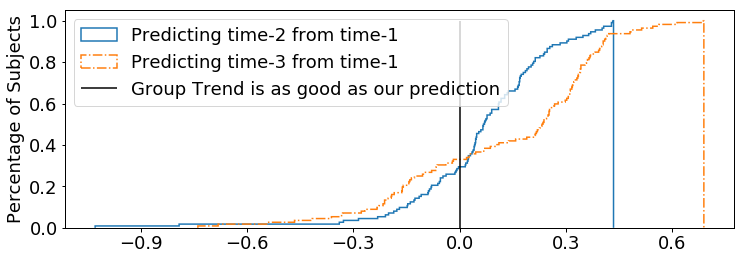

In [347]:
plt.rcParams.update({'font.size': 18,'xtick.major.width'   : 1,'ytick.major.width'   : 1,'axes.linewidth' : 1})
n_bins = 1000

fig, ax = plt.subplots(figsize=(12, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist(value_1, n_bins, density=True, histtype='step',
                           cumulative=True, linestyle = '-',label='Predicting time-2 from time-1',linewidth=1.5)
n, bins, patches = ax.hist(value_2, n_bins, density=True, histtype='step',
                           cumulative=True, linestyle = '-.',label='Predicting time-3 from time-1',linewidth=1.5)
my_x_ticks = np.arange(-1.5, 0.7, 0.3)
my_y_ticks = np.arange(-0., 1.1, 0.2)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.vlines(0,0,1,color = 'k',label="Group Trend is as good as our prediction")
# tidy up the figure
ax.legend(loc='upper left')
#ax.set_xlabel('The Persentage That Our Prediction Better Off Compared with the Base Line')
ax.set_ylabel('Percentage of Subjects')

plt.show()

# Evaluation on test data from t1 to t2

In [47]:
integration_t= torch.tensor([0,0.3]).float()###############time
list_y = []
list_x = []
list_z = []
for j in range(0,10):
    X_train, X_test, y_train, y_test, L_train, L_test, index = get_batch(pib_v1, pib_v2, Connect_v1, s=j)
    X_train = torch.tensor(X_train).float()
    X_test = torch.tensor(X_test).float()
    y_train = torch.tensor(y_train).float()
    y_test = torch.tensor(y_test).float()
    L_train = torch.tensor(L_train).float()
    L_test = torch.tensor(L_test).float()
    
    model.load_state_dict(torch.load('./'+ str(j) + '.pth'))
    for i in range(0,len(y_test)):
        temp_1 = evaluate_2( y_test, model(integration_t,X_test[i], L_test[i])[1],i, len(y_test))
        temp_2 = evaluate_1(y_test[i], model(integration_t,X_test[i], L_test[i])[1], 100)
        temp_3 = evaluate_3(y_test, model(integration_t,X_test[i], L_test[i])[1],i, 100)
        list_y.append(temp_1)
        list_x.append(temp_2)
        list_z.append(temp_3)
        #print(temp)

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


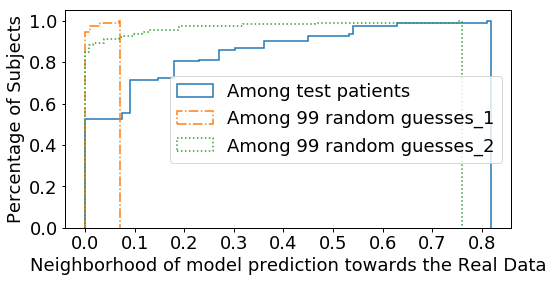

In [48]:
plt.rcParams.update({'font.size': 18,'xtick.major.width'   : 1,'ytick.major.width'   : 1,'axes.linewidth' : 1})
n_bins = 100

fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist(list_y, n_bins, density=True, histtype='step',
                           cumulative=True, linestyle = '-',label='Among test patients',linewidth=1.5)
n, bins, patches = ax.hist(list_x, n_bins, density=True, histtype='step',
                           cumulative=True, linestyle = '-.',label='Among 99 random guesses_1',linewidth=1.5)
n, bins, patches = ax.hist(list_z, n_bins, density=True, histtype='step',
                           cumulative=True, linestyle = ':',label='Among 99 random guesses_2',linewidth=1.5)
my_x_ticks = np.arange(-0., 0.9, 0.1)
my_y_ticks = np.arange(-0., 1.1, 0.2)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
# tidy up the figure
ax.legend(loc='right')
ax.set_xlabel('Neighborhood of model prediction towards the Real Data')
ax.set_ylabel('Percentage of Subjects')

plt.show()

# Evaluation on test data from t1 to t3

In [49]:
integration_t= torch.tensor([0,0.4]).float()###############time
X_train = torch.tensor(pib_v1).float()
X_test = torch.tensor(pib_v1).float()
y_train = torch.tensor(pib_v2).float()
y_test = torch.tensor(pib_v3).float()
L_train = torch.tensor(Connect_v1).float()
L_test = torch.tensor(Connect_v1).float()

list_y = []
list_x = []
list_z = []
for i in range(0,len(y_test)):
    temp_1 = evaluate_2( y_test, model(integration_t,X_test[i], L_test[i])[1],i, len(y_test))
    temp_2 = evaluate_1(y_test[i], model(integration_t,X_test[i], L_test[i])[1], 100)
    temp_3 = evaluate_3(y_test, model(integration_t,X_test[i], L_test[i])[1],i, 100)
    list_y.append(temp_1)
    list_x.append(temp_2)
    list_z.append(temp_3)
    #print(temp)

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


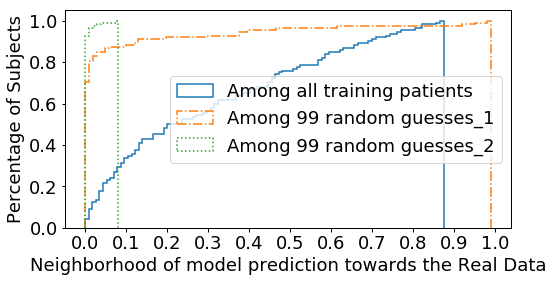

In [52]:
plt.rcParams.update({'font.size': 18,'xtick.major.width'   : 1,'ytick.major.width'   : 1,'axes.linewidth' : 1})
n_bins = 100

fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist(list_y, n_bins, density=True, histtype='step',
                           cumulative=True, linestyle = '-',label='Among all training patients',linewidth=1.5)
n, bins, patches = ax.hist(list_x, n_bins, density=True, histtype='step',
                           cumulative=True, linestyle = '-.',label='Among 99 random guesses_1',linewidth=1.5)
n, bins, patches = ax.hist(list_z, n_bins, density=True, histtype='step',
                           cumulative=True, linestyle = ':',label='Among 99 random guesses_2',linewidth=1.5)


my_x_ticks = np.arange(-0., 1.1, 0.1)
my_y_ticks = np.arange(-0., 1.1, 0.2)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
# tidy up the figure
ax.legend(loc='right')
ax.set_xlabel('Neighborhood of model prediction towards the Real Data')
ax.set_ylabel('Percentage of Subjects')

plt.show()